Creates plots of any model with errorbars, but does not match up with datapoints atm.

In [1]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import lolopy.learners #allows easy uncertainty
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps
import forestci as fci #confidence intervals for RFR - http://contrib.scikit-learn.org/forest-confidence-interval/index.html

#regression models:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

In [9]:
################################################
############ Define Import Function ############
################################################
#imports the data from get_featurizers. Function because some models we may want infinity:
def import_data(replace_inf=False):
    global data, target, train_data, test_data, train_target, test_target, cal_data, cal_target #variables that we want to define globally (outside of this funtion)
    data = pd.DataFrame(pd.read_csv('../data/supercon_features.csv')) #loads data produced in get_featurizer.ipynb
    target = data.pop('Tc') #remove target (critical temp) from data

    if replace_inf: #replaces values of infinity with NaN if replace_inf is True
        data.replace([np.inf, -np.inf], np.nan, inplace=True) 

    #TODO: debug feaurizers - NaN is entered when there is an error in the featurizer
    data.drop(['name','Unnamed: 0', 'composition'], axis=1, inplace=True) #drop columns irrelevant to training
    data = data[data.columns[data.notnull().any()]] #drop columns that are entirely NaN (12 columns) 

    for col in data: #replaces NaN with zeros
        data[col] = pd.to_numeric(data[col], errors ='coerce').fillna(0).astype('float')

    #creates a test train split, with shuffle and random state for reproducibility 
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.15, random_state=43, shuffle=True)

###############################################
######### Define Evaluation Functions #########
###############################################
def evaluate_one(model_name, model, parameters, error=True, method="plus", forestci=False, export=False):
    #define function that trains a model to predict critical temp and plots with metrics and optional error 
    #error and forestci arguments override method specifications. forestci is much faster than mapie and is only applicable to random forest models
    global train_data, train_data, test_data, test_target #we need these variables and don't want to pass them as arguments
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#1e1e1e','text.color':'white','legend.labelcolor':'black'}):
        warnings.filterwarnings("ignore")
        plt.title(f"{model_name} - Prediction vs. Actual Value (CV)", color='white')
        regressor = model(**parameters)

        if error and not forestci and method != "prefit": #error calculations need magie training if not forestci/prefit mapie
            mapie_regressor = MapieRegressor(estimator=regressor, method=method) #unpacks model and params
            if model_name in ("Superlearner", "Random Forest Regression - Lolopy"): #need to get values for these models
                mapie_regressor.fit(train_data.values, train_target.values) #fit the model
            else:
                mapie_regressor.fit(train_data, train_target) #fit the model
                model_pred, model_pis = mapie_regressor.predict(test_data, alpha=0.05) #make predictions on test data
        else: #no need for error calculations during training, use sklearn
            if model_name in ("Superlearner", "Random Forest Regression - Lolopy"): #need to get values for these models
                regressor.fit(train_data.values, train_target.values) #fit the model
            else:
                regressor.fit(train_data, train_target) #fit the model

        mse = round(mean_squared_error(test_target, model_pred),3) #find mean square error
        mae = round(mean_absolute_error(test_target, model_pred),3) #find mean square error
        mxe = round(max_error(test_target, model_pred),3)
        r_squared = round(r2_score(test_target, model_pred),3) #find r2 score

        #make our plot - with plt.rc_context sets theme to look good in dark mode
        difference = np.abs(test_target - model_pred) #function that finds the absolute difference between predicted and actual value
        im = plt.scatter(model_pred, test_target, cmap='plasma_r', norm=plt.Normalize(0, 120), c=difference, label="Critical Temperature (K)", zorder=2) #create scatter plot of data 
        plt.plot((0,135), (0,135), 'k--', alpha=0.75, zorder=3) #add expected line. Values must be changed with different data to look good
        if error: #plot error bars
            if forestci:
                model_unbiased = fci.random_forest_error(regressor, train_data, test_data, calibrate=False)
                xerror = np.sqrt(model_unbiased)
            if method == "prefit":
                raise NameError("Prefit method is not implemented in this program as our current implementation have error bars that do not align with the test data")
                # mapie = MapieRegressor(estimator=model, cv="prefit").fit(cal_data, cal_target) #important: calibration data must be different from training data!
                # pred_interval = pd.DataFrame(mapie.predict(test_data, alpha=.05)[1].reshape(-1,2), index=test_data.index, columns=["lower", "upper"]) #get interval predictions on test data, with alpha=5%
                # xerror = pred_interval.values.reshape(2,-1)
            else:
                #model_pis contains absolute points for upper/lower bounds. We need absolute error, like (3, 3) for ± 3:
                xerror = np.abs(model_pis[:,:,0].transpose() - np.tile(model_pred, (2, 1))) #error must be in shape (n, 2) for errorbars
            plt.errorbar(model_pred, test_target, xerr=xerror, fmt=".", ecolor="black", alpha=0.5, zorder=1)
        plt.title(model_name, c='white')
        plt.ylabel('Actual Value', c='white')
        plt.xlabel('Prediction', c='white')
        plt.annotate(f'R2: {r_squared}', xy = (0, -0.15), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MXE: {mxe}', xy = (0, -0.20), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MAE: {mae}', xy = (1.0, -0.20), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MAE
        plt.annotate(f'MSE: {mse}', xy = (1.0, -0.15), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MSE
        plt.legend()
        plt.colorbar().set_label(label="Difference from Actual (K)", color='white') #using .set_label() as colorbar() does accept color arguments
        if export:
            plt.savefig(f'../data/{model_name}.png', bbox_inches='tight')
        plt.show()
        plt.clf()

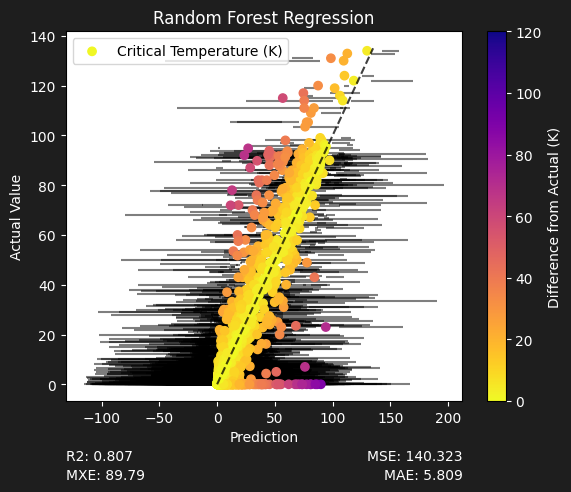

<Figure size 640x480 with 0 Axes>

In [4]:
import_data(replace_inf=True)
evaluate_one("Random Forest Regression", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, error=True, forestci=True) #NOTE: forestci calibration is disabled as there is a bug in the code (they use a too small datatype)
#compare with lolopy

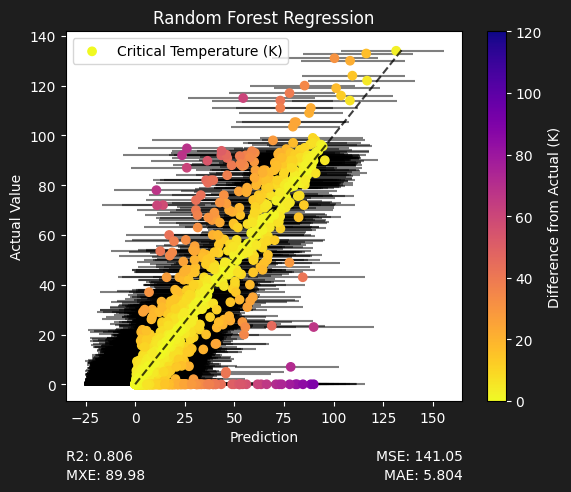

<Figure size 640x480 with 0 Axes>

In [11]:
import_data(replace_inf=True)
evaluate_one("Random Forest Regression", RandomForestRegressor, {'max_features': 'auto', 'n_estimators': 300}, error=True) #NOTE: forestci calibration is disabled as there is a bug in the code (they use a too small datatype)
#compare with lolopy

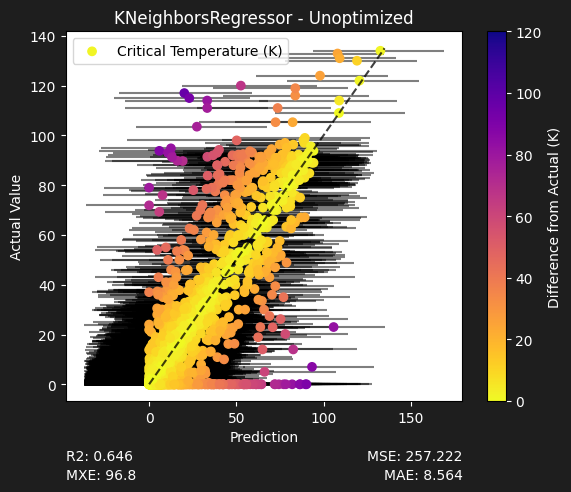

<Figure size 640x480 with 0 Axes>

In [10]:
import_data(replace_inf=True)
evaluate_one("KNeighborsRegressor - Unoptimized", KNeighborsRegressor, {}, error=True)

In [12]:
(model_pis[:,:,0].transpose() - np.tile(model_pred, (2, 1))).shape

(2, 2463)